# HW6 Clustering
20220041

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('survey.csv')
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8440 entries, 0 to 8439
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                8440 non-null   int64 
 1   education          8440 non-null   object
 2   education level    8440 non-null   int64 
 3   marital status     8440 non-null   object
 4   Occupation         8440 non-null   object
 5   relationship       8440 non-null   object
 6   race               8440 non-null   object
 7   sex                8440 non-null   object
 8   Investment profit  8440 non-null   int64 
 9   Investment loss    8440 non-null   int64 
 10  hours per week     8440 non-null   int64 
 11  native country     8440 non-null   object
 12  income             8440 non-null   object
dtypes: int64(5), object(8)
memory usage: 857.3+ KB
None
               age  education level  Investment profit  Investment loss  \
count  8440.000000      8440.000000        8440.000000  

In [3]:
sel_df = df.drop(columns=['age', 'marital status', 'relationship', 'race', 'sex', 'native country', 'Investment profit', 'Investment loss'])
print(sel_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8440 entries, 0 to 8439
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   education        8440 non-null   object
 1   education level  8440 non-null   int64 
 2   Occupation       8440 non-null   object
 3   hours per week   8440 non-null   int64 
 4   income           8440 non-null   object
dtypes: int64(2), object(3)
memory usage: 329.8+ KB
None


In [4]:
encoder = LabelEncoder()
sel_df['education'] = encoder.fit_transform(sel_df['education'])
sel_df['Occupation'] = encoder.fit_transform(sel_df['Occupation'])
sel_df['income'] = encoder.fit_transform(sel_df['income'])
print(sel_df.head())


   education  education level  Occupation  hours per week  income
0          4                3           3              20       0
1         10                9           3              50       0
2         14               10           3              46       0
3          6                5           2              40       0
4          3                2           2              40       0


In [5]:
def plot_clusters(data, labels, title):
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(data)
    plt.figure(figsize=(8, 6))
    #sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=labels, palette='Set2')
    sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=labels, palette='Set2', s=50, alpha=0.5)

    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(title="Cluster")
    plt.show()

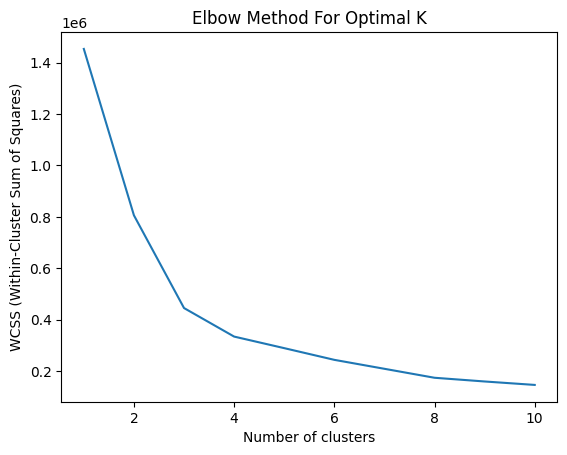

In [6]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(sel_df)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method For Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

In [7]:
kmeans = KMeans(n_clusters=5, random_state=60)
kmeans_labels = kmeans.fit_predict(sel_df)
silhouette_kmeans = silhouette_score(sel_df, kmeans_labels)
print(f'Silhouette Score (KMeans): {silhouette_kmeans}')

Silhouette Score (KMeans): 0.45818722760856806


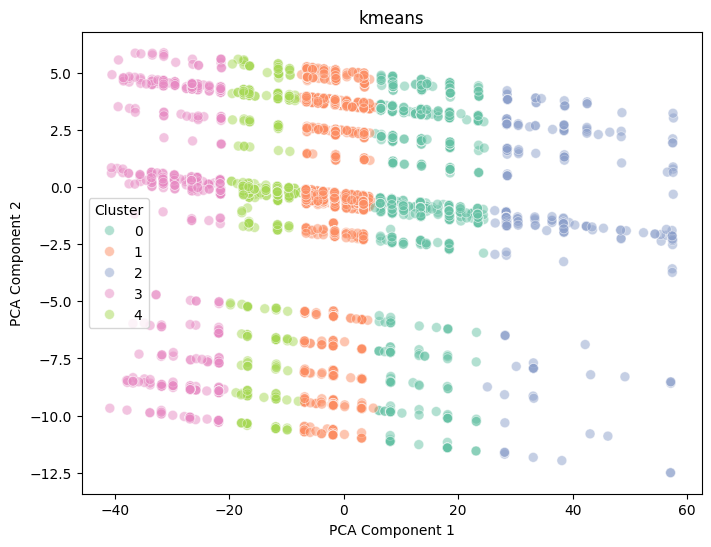

In [8]:
kmeans_df = pd.DataFrame( {
    'ID': range(len(df)),
    'Employment Type': kmeans_labels
})
kmeans_df.to_csv('km3.csv', index=False)
plot_clusters(sel_df, kmeans_labels, 'kmeans')

In [9]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(sel_df)
print(silhouette_score(sel_df, dbscan_labels))
dbscan_df = pd.DataFrame({
    'ID': df.index,
    'Employment Type': dbscan_labels
})
#dbscan_df.to_csv('dbscan.csv',index=False)
#plot_clusters(sel_df, dbscan_labels, 'dbscan')

0.6125911828095912


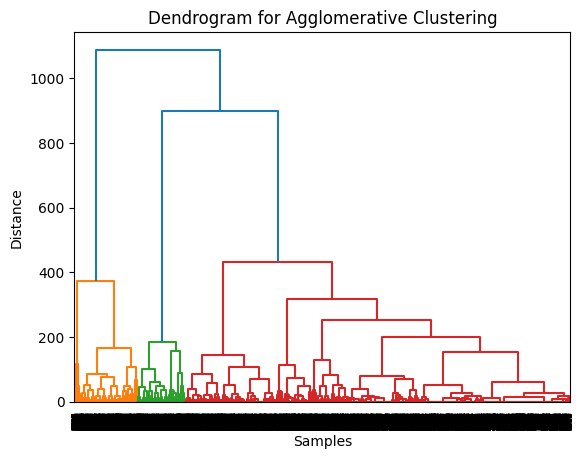

In [10]:
import scipy.cluster.hierarchy as sch

dendrogram = sch.dendrogram(sch.linkage(sel_df, method='ward'))
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

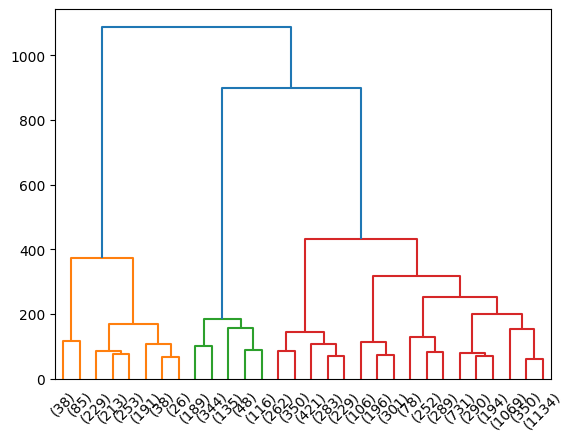

In [11]:
dendrogram = sch.dendrogram(sch.linkage(sel_df, method='ward'), truncate_mode='lastp', p=30)
plt.show()

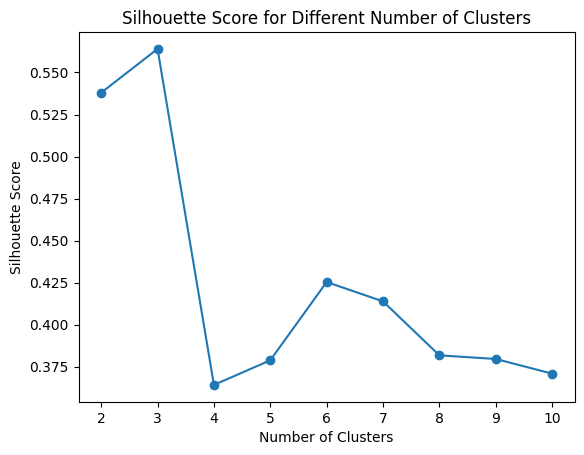

In [12]:
sil_scores = []
for n_clusters in range(2, 11):
    agg_clust = AgglomerativeClustering(n_clusters=n_clusters)
    labels = agg_clust.fit_predict(sel_df)
    score = silhouette_score(sel_df, labels)
    sil_scores.append(score)

plt.plot(range(2, 11), sil_scores, marker='o')
plt.title('Silhouette Score for Different Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

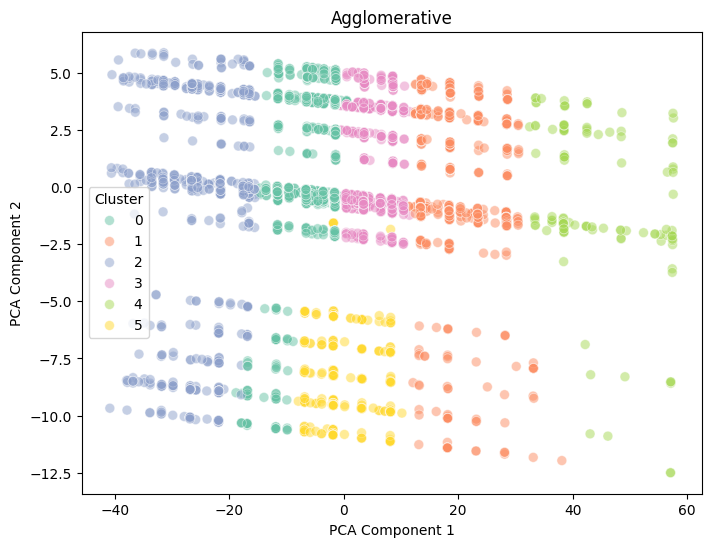

In [13]:
agg = AgglomerativeClustering(n_clusters=6)
agg_labels = agg.fit_predict(sel_df)
agg_df = pd.DataFrame({
    'ID': df.index,
    'Employment Type': agg_labels
})
agg_df.to_csv('agg3.csv',index=False)
plot_clusters(sel_df, agg_labels, 'Agglomerative')


In [14]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(sel_df, quantile=0.2, n_samples=400)
print(bandwidth)
mean_shift = MeanShift(bandwidth=bandwidth)
mean_shift_labels = mean_shift.fit_predict(sel_df)
sil_mean_shift = silhouette_score(sel_df, mean_shift_labels)
print(sil_mean_shift)

9.200230476562629
0.5185458284699319


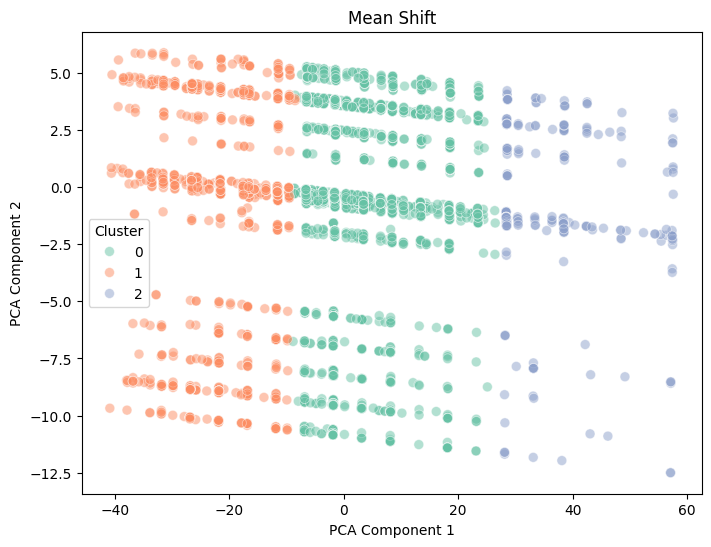

In [15]:
ms_df = pd.DataFrame({
    'ID': df.index,
    'Employment Type': mean_shift_labels
})
ms_df.to_csv('ms2.csv',index=False)
plot_clusters(sel_df, mean_shift_labels, 'Mean Shift')
